# Generating training cosmologies.

In this notebook we generate samples from a $\Lambda$CDM parameter space that will be used to train the components of `EFTEMU`.

For this work we use two publically available suites of simulations to map out a region of the parameter space that we would be interested in generating samples in. Those two suite are:
1. Aemulus ([DeRose et al. 2018](https://arxiv.org/abs/1804.05865)).
2. AbacusSummit ([Maksimova et al 2021](https://arxiv.org/abs/2110.11398)).

These two suites sample from a beyond $\Lambda$CDM cosmological parameter space, however the $\Lambda$CDM parameters that they share cover an approximately 5-8$\sigma$ region around the Planck 2018 cosmology.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matryoshka.plot import sample_space
from matryoshka.training_funcs import Resampler

As with most of the other notebooks in this repo we start by specifying the repo location.

In [2]:
path_to_repo = "/Users/jamie/Desktop/GitHubProjects/matryoshka_II_paper/"

Next we load the $\Lambda$CDM parameters of the two simulation suites (the origonal versions of these files are publically available, see the [Aemulus](https://aemulusproject.github.io/dataproducts.html) and [AbacusSummit](https://abacussummit.readthedocs.io/en/latest/data-access.html) docs for data access details).

In [3]:
ABACUS_SUMMIT = np.loadtxt(path_to_repo+"data/sim_suites/AbacusSummit-Cosmologies-Cut.csv",
                           usecols=[1,0,2,3,4], delimiter=',', skiprows=1)
AEMULUS = np.loadtxt(path_to_repo+"data/sim_suites/Aemulus.txt", skiprows=1, usecols=[2,1,6,5,4])

We then make sure that the parameters are in the form we want.

In [4]:
ABACUS_SUMMIT[:,3] = np.log(ABACUS_SUMMIT[:,3]*10**10) # ln 10^10 As
AEMULUS[:,2] = AEMULUS[:,2]/100 # h

Now we use `Resampler` to generate 10000 latin-hypercube samples from the region covered by the simulation suites. 

In [5]:
resampler = Resampler(np.vstack([AEMULUS, ABACUS_SUMMIT]), use_latent_space=False)
new_samples = resampler.new_samples(10000, buffer=0.)

We can examine the width of our training space compared to [Planck 2018](https://arxiv.org/abs/1807.06209) results. We look at the number of $\sigma$ each sample is away from the $\Lambda$CDM TT, TE, EE + lowE + lensing + BAO results in each dimension.

In [6]:
cosmo_true = np.array([0.11933, 0.02242, 0.6766, 3.047, 0.9665])
cosmo_true_stddev = np.array([0.00091, 0.00014, 0.0042, 0.014, 0.0038])

nstddev = (new_samples-cosmo_true)/cosmo_true_stddev

min(np.abs(nstddev).max(axis=0)), max(np.abs(nstddev).max(axis=0))

(13.283914738919378, 24.3087459237801)

Now we can save the new samples. We ask for a user input here to **make sure** you want to save the samples and accidently overwrite some that have already been used for training.

In [7]:
save = input("Save the generated samples (y/n): ")

if save is 'y':
    save_dir = path_to_repo+"data/training/cosmologies/"
    np.save(save_dir+"eft_cosmologies.npy", new_samples)
    print("New samples saved!")

Save the generated samples (y/n): n


## Figure 1 from paper

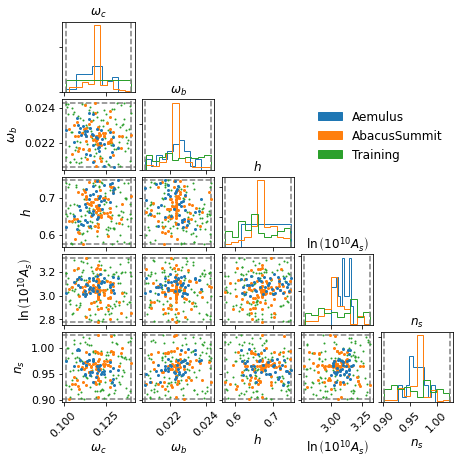

In [8]:
sample_space([AEMULUS, ABACUS_SUMMIT, new_samples[::100,:]],
             [r'$\omega_c$', r'$\omega_b$', r'$h$', r'$\ln{\left(10^{10}A_s\right)}$', r'$n_s$'],
             figsize=(7,7), set_labels=["Aemulus", "AbacusSummit", "Training"], 
             bounds=np.stack([new_samples.min(axis=0), new_samples.max(axis=0)]).T, 
             bounds_colour='grey', marker_sizes=[4.,4.,1.], save=True, 
             filename=path_to_repo+"plots/eftemu_cosmo_space.png", 
             leg_label_size=12, tick_label_size=11)